# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

% matplotlib inline

% load_ext autoreload
% autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0

    # Subtract mean
    mean_image = np.mean(train_flat, axis=0)
    train_flat -= mean_image
    test_flat -= mean_image

    return train_flat, test_flat


train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val=1000)

<ipython-input-3-6cc8c6fecdee>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
<ipython-input-3-6cc8c6fecdee>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0


# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [4]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1, -2, 3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [5]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [6]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=3, reg=0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for FL1_W
Gradient check passed!
Checking gradient for FL1_B
Gradient check passed!
Checking gradient for FL2_W
Gradient check passed!
Checking gradient for FL2_B
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [7]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=3, reg=1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss),
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for FL1_W
Gradient check passed!
Checking gradient for FL1_B
Gradient check passed!
Checking gradient for FL2_W
Gradient check passed!
Checking gradient for FL2_B
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [8]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30])

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [10]:
model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Epoch: 10
Loss: 0.6863240857696062, Train accuracy: 0.7314444444444445, val accuracy: 0.683
Epoch: 20
Loss: 0.7320997602417517, Train accuracy: 0.7955555555555556, val accuracy: 0.732


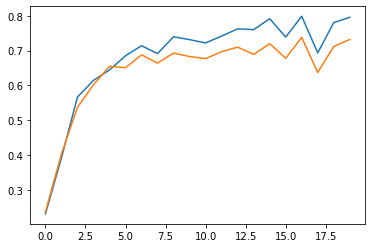

In [11]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [12]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5 * initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Epoch: 10
Loss: 1.3877270695051134, Train accuracy: 0.7315555555555555, val accuracy: 0.689
Epoch: 20
Loss: 1.6308008472078446, Train accuracy: 0.7834444444444445, val accuracy: 0.705


# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [13]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-2, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Epoch: 10
Loss: 1.561947330906185, Train accuracy: 0.7583333333333333, val accuracy: 0.724
Reached accuracy limit at epoch 17


# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [14]:
data_size = 15
model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Reached accuracy limit at epoch 5


Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [15]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=100, reg=0)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=5e-1, num_epochs=20, batch_size=10)

loss_history, train_history, val_history = trainer.fit()

Reached accuracy limit at epoch 4


# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [16]:
# Let's train the best one-hidden-layer network we can

learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]
reg_strength = [1, 1e-1, 1e-2, 1e-3, 1e-4]
learning_rate_decay = [0.999, 0.99, 0.95]
hidden_layer_size = [10, 32, 64, 128]
num_epochs = [20, 100, 200]
batch_size = [16, 32, 64, 128]

best_classifier = None
best_val_accuracy = 0
best_hypers = None

loss_history = []
train_history = []
val_history = []

for lr in learning_rates:
    for rs in reg_strength:
        for lrd in learning_rate_decay:
            for hls in hidden_layer_size:
                for ne in num_epochs:
                    for bs in batch_size:
                        model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=hls, reg=rs)
                        dataset = Dataset(train_X, train_y, val_X, val_y)
                        trainer = Trainer(model, dataset, SGD(), learning_rate=lr, learning_rate_decay=lrd,
                                          num_epochs=ne, batch_size=bs)
                        l_history, t_history, v_history = trainer.fit(logging_enabled=False)
                        cur_accuracy = v_history[-1]
                        print(
                            f"Learning Rate={lr}\tReg Strength={rs}\tLearning Decay Rate={lrd}\nHidden Layer size={hls}\tNum of Epochs={ne}\tBatch size={bs}\nAccuracy={cur_accuracy}\n\n")

                        if best_val_accuracy < cur_accuracy:
                            best_val_accuracy = cur_accuracy
                            best_classifier = model
                            best_hypers = [lr, rs, lrd, hls, ne, bs]
                            loss_history = l_history
                            train_history = t_history
                            val_history = v_history

print('best validation accuracy achieved: %f' % best_val_accuracy)

Reached accuracy limit at epoch 5
Learning Rate=0.1	Reg Strength=1	Learning Decay Rate=0.999
Hidden Layer size=10	Num of Epochs=20	Batch size=16
Accuracy=0.14


Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=1	Learning Decay Rate=0.999
Hidden Layer size=10	Num of Epochs=20	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=1	Learning Decay Rate=0.999
Hidden Layer size=10	Num of Epochs=20	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=1	Learning Decay Rate=0.999
Hidden Layer size=10	Num of Epochs=20	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 5
Learning Rate=0.1	Reg Strength=1	Learning Decay Rate=0.999
Hidden Layer size=10	Num of Epochs=100	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=1	Learning Decay Rate=0.999
Hidden Layer size=10	Num of Epochs=100	Batch size=32
Accuracy=0.206


Reached accuracy limit at 

Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=1	Learning Decay Rate=0.99
Hidden Layer size=10	Num of Epochs=20	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=1	Learning Decay Rate=0.99
Hidden Layer size=10	Num of Epochs=100	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 6
Learning Rate=0.1	Reg Strength=1	Learning Decay Rate=0.99
Hidden Layer size=10	Num of Epochs=100	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=1	Learning Decay Rate=0.99
Hidden Layer size=10	Num of Epochs=100	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=1	Learning Decay Rate=0.99
Hidden Layer size=10	Num of Epochs=100	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=1	Learning Decay Rate=0.99
Hidden Layer size=10	Num of Epochs=200	Batch size=16
Accuracy=0.206


Reached accuracy limit at e

Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=1	Learning Decay Rate=0.95
Hidden Layer size=10	Num of Epochs=100	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=1	Learning Decay Rate=0.95
Hidden Layer size=10	Num of Epochs=100	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=1	Learning Decay Rate=0.95
Hidden Layer size=10	Num of Epochs=200	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=1	Learning Decay Rate=0.95
Hidden Layer size=10	Num of Epochs=200	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=1	Learning Decay Rate=0.95
Hidden Layer size=10	Num of Epochs=200	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=1	Learning Decay Rate=0.95
Hidden Layer size=10	Num of Epochs=200	Batch size=128
Accuracy=0.206


Reached accuracy limit at 

Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=0.1	Learning Decay Rate=0.999
Hidden Layer size=10	Num of Epochs=200	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=0.1	Learning Decay Rate=0.999
Hidden Layer size=10	Num of Epochs=200	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=0.1	Learning Decay Rate=0.999
Hidden Layer size=10	Num of Epochs=200	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=0.1	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=20	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=0.1	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=20	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=0.1	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=20	Batch size=64
Accuracy=0.206


Reached accu

Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=0.1	Learning Decay Rate=0.99
Hidden Layer size=10	Num of Epochs=200	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=0.1	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=20	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=0.1	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=20	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=0.1	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=20	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=0.1	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=20	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 8
Learning Rate=0.1	Reg Strength=0.1	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=100	Batch size=16
Accuracy=0.206


Reached accuracy l

Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=0.1	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=20	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=0.1	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=20	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=0.1	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=20	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 6
Learning Rate=0.1	Reg Strength=0.1	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=100	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=0.1	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=100	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=0.1	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=100	Batch size=64
Accuracy=0.206


Reached accuracy l

Reached accuracy limit at epoch 42
Learning Rate=0.1	Reg Strength=0.01	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=100	Batch size=16
Accuracy=0.554


Learning Rate=0.1	Reg Strength=0.01	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=100	Batch size=32
Accuracy=0.557


Reached accuracy limit at epoch 22
Learning Rate=0.1	Reg Strength=0.01	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=100	Batch size=64
Accuracy=0.596


Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=0.01	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=100	Batch size=128
Accuracy=0.206


Learning Rate=0.1	Reg Strength=0.01	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=200	Batch size=16
Accuracy=0.487


Learning Rate=0.1	Reg Strength=0.01	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=200	Batch size=32
Accuracy=0.596


Reached accuracy limit at epoch 25
Learning Rate=0.1	Reg Strength=0.01	Learning Decay Rate=0.999
Hidden

Reached accuracy limit at epoch 67
Learning Rate=0.1	Reg Strength=0.01	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=200	Batch size=64
Accuracy=0.656


Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=0.01	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=200	Batch size=128
Accuracy=0.206


Learning Rate=0.1	Reg Strength=0.01	Learning Decay Rate=0.99
Hidden Layer size=64	Num of Epochs=20	Batch size=16
Accuracy=0.559


Learning Rate=0.1	Reg Strength=0.01	Learning Decay Rate=0.99
Hidden Layer size=64	Num of Epochs=20	Batch size=32
Accuracy=0.584


Learning Rate=0.1	Reg Strength=0.01	Learning Decay Rate=0.99
Hidden Layer size=64	Num of Epochs=20	Batch size=64
Accuracy=0.592


Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=0.01	Learning Decay Rate=0.99
Hidden Layer size=64	Num of Epochs=20	Batch size=128
Accuracy=0.206


Learning Rate=0.1	Reg Strength=0.01	Learning Decay Rate=0.99
Hidden Layer size=64	Num of Epochs=100	Batch size=16

Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=0.01	Learning Decay Rate=0.95
Hidden Layer size=64	Num of Epochs=20	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 28
Learning Rate=0.1	Reg Strength=0.01	Learning Decay Rate=0.95
Hidden Layer size=64	Num of Epochs=100	Batch size=16
Accuracy=0.65


Reached accuracy limit at epoch 72
Learning Rate=0.1	Reg Strength=0.01	Learning Decay Rate=0.95
Hidden Layer size=64	Num of Epochs=100	Batch size=32
Accuracy=0.672


Reached accuracy limit at epoch 61
Learning Rate=0.1	Reg Strength=0.01	Learning Decay Rate=0.95
Hidden Layer size=64	Num of Epochs=100	Batch size=64
Accuracy=0.628


Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=0.01	Learning Decay Rate=0.95
Hidden Layer size=64	Num of Epochs=100	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 39
Learning Rate=0.1	Reg Strength=0.01	Learning Decay Rate=0.95
Hidden Layer size=64	Num of Epochs=200	Batch size=16
Accuracy=0.664


Reache

Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=0.001	Learning Decay Rate=0.999
Hidden Layer size=64	Num of Epochs=100	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 46
Learning Rate=0.1	Reg Strength=0.001	Learning Decay Rate=0.999
Hidden Layer size=64	Num of Epochs=200	Batch size=16
Accuracy=0.713


Reached accuracy limit at epoch 51
Learning Rate=0.1	Reg Strength=0.001	Learning Decay Rate=0.999
Hidden Layer size=64	Num of Epochs=200	Batch size=32
Accuracy=0.692


Reached accuracy limit at epoch 21
Learning Rate=0.1	Reg Strength=0.001	Learning Decay Rate=0.999
Hidden Layer size=64	Num of Epochs=200	Batch size=64
Accuracy=0.695


Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=0.001	Learning Decay Rate=0.999
Hidden Layer size=64	Num of Epochs=200	Batch size=128
Accuracy=0.206


Learning Rate=0.1	Reg Strength=0.001	Learning Decay Rate=0.999
Hidden Layer size=128	Num of Epochs=20	Batch size=16
Accuracy=0.624


Learning Rate=0.1	Reg Stren

Learning Rate=0.1	Reg Strength=0.001	Learning Decay Rate=0.99
Hidden Layer size=128	Num of Epochs=20	Batch size=16
Accuracy=0.715


Learning Rate=0.1	Reg Strength=0.001	Learning Decay Rate=0.99
Hidden Layer size=128	Num of Epochs=20	Batch size=32
Accuracy=0.68


Reached accuracy limit at epoch 12
Learning Rate=0.1	Reg Strength=0.001	Learning Decay Rate=0.99
Hidden Layer size=128	Num of Epochs=20	Batch size=64
Accuracy=0.64


Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=0.001	Learning Decay Rate=0.99
Hidden Layer size=128	Num of Epochs=20	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 32
Learning Rate=0.1	Reg Strength=0.001	Learning Decay Rate=0.99
Hidden Layer size=128	Num of Epochs=100	Batch size=16
Accuracy=0.733


Reached accuracy limit at epoch 39
Learning Rate=0.1	Reg Strength=0.001	Learning Decay Rate=0.99
Hidden Layer size=128	Num of Epochs=100	Batch size=32
Accuracy=0.74


Reached accuracy limit at epoch 52
Learning Rate=0.1	Reg Strength=0.0

Reached accuracy limit at epoch 59
Learning Rate=0.1	Reg Strength=0.001	Learning Decay Rate=0.95
Hidden Layer size=128	Num of Epochs=100	Batch size=16
Accuracy=0.791


Reached accuracy limit at epoch 28
Learning Rate=0.1	Reg Strength=0.001	Learning Decay Rate=0.95
Hidden Layer size=128	Num of Epochs=100	Batch size=32
Accuracy=0.747


Reached accuracy limit at epoch 22
Learning Rate=0.1	Reg Strength=0.001	Learning Decay Rate=0.95
Hidden Layer size=128	Num of Epochs=100	Batch size=64
Accuracy=0.693


Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=0.001	Learning Decay Rate=0.95
Hidden Layer size=128	Num of Epochs=100	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 42
Learning Rate=0.1	Reg Strength=0.001	Learning Decay Rate=0.95
Hidden Layer size=128	Num of Epochs=200	Batch size=16
Accuracy=0.78


Reached accuracy limit at epoch 31
Learning Rate=0.1	Reg Strength=0.001	Learning Decay Rate=0.95
Hidden Layer size=128	Num of Epochs=200	Batch size=32
Accuracy=0

Reached accuracy limit at epoch 46
Learning Rate=0.1	Reg Strength=0.0001	Learning Decay Rate=0.999
Hidden Layer size=128	Num of Epochs=200	Batch size=16
Accuracy=0.748


Reached accuracy limit at epoch 96
Learning Rate=0.1	Reg Strength=0.0001	Learning Decay Rate=0.999
Hidden Layer size=128	Num of Epochs=200	Batch size=32
Accuracy=0.772


Reached accuracy limit at epoch 56
Learning Rate=0.1	Reg Strength=0.0001	Learning Decay Rate=0.999
Hidden Layer size=128	Num of Epochs=200	Batch size=64
Accuracy=0.747


Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=0.0001	Learning Decay Rate=0.999
Hidden Layer size=128	Num of Epochs=200	Batch size=128
Accuracy=0.206


Learning Rate=0.1	Reg Strength=0.0001	Learning Decay Rate=0.99
Hidden Layer size=10	Num of Epochs=20	Batch size=16
Accuracy=0.536


Learning Rate=0.1	Reg Strength=0.0001	Learning Decay Rate=0.99
Hidden Layer size=10	Num of Epochs=20	Batch size=32
Accuracy=0.555


Learning Rate=0.1	Reg Strength=0.0001	Learning Decay Rat

Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=0.0001	Learning Decay Rate=0.99
Hidden Layer size=128	Num of Epochs=200	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 19
Learning Rate=0.1	Reg Strength=0.0001	Learning Decay Rate=0.95
Hidden Layer size=10	Num of Epochs=20	Batch size=16
Accuracy=0.542


Reached accuracy limit at epoch 13
Learning Rate=0.1	Reg Strength=0.0001	Learning Decay Rate=0.95
Hidden Layer size=10	Num of Epochs=20	Batch size=32
Accuracy=0.552


Reached accuracy limit at epoch 15
Learning Rate=0.1	Reg Strength=0.0001	Learning Decay Rate=0.95
Hidden Layer size=10	Num of Epochs=20	Batch size=64
Accuracy=0.469


Reached accuracy limit at epoch 4
Learning Rate=0.1	Reg Strength=0.0001	Learning Decay Rate=0.95
Hidden Layer size=10	Num of Epochs=20	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 31
Learning Rate=0.1	Reg Strength=0.0001	Learning Decay Rate=0.95
Hidden Layer size=10	Num of Epochs=100	Batch size=16
Accuracy=0.6

Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=1	Learning Decay Rate=0.999
Hidden Layer size=10	Num of Epochs=20	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=1	Learning Decay Rate=0.999
Hidden Layer size=10	Num of Epochs=20	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=1	Learning Decay Rate=0.999
Hidden Layer size=10	Num of Epochs=100	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=1	Learning Decay Rate=0.999
Hidden Layer size=10	Num of Epochs=100	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=1	Learning Decay Rate=0.999
Hidden Layer size=10	Num of Epochs=100	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=1	Learning Decay Rate=0.999
Hidden Layer size=10	Num of Epochs=100	Batch size=128
Accuracy=0.206


Reached accuracy

Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=1	Learning Decay Rate=0.99
Hidden Layer size=10	Num of Epochs=100	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=1	Learning Decay Rate=0.99
Hidden Layer size=10	Num of Epochs=100	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=1	Learning Decay Rate=0.99
Hidden Layer size=10	Num of Epochs=100	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=1	Learning Decay Rate=0.99
Hidden Layer size=10	Num of Epochs=100	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=1	Learning Decay Rate=0.99
Hidden Layer size=10	Num of Epochs=200	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=1	Learning Decay Rate=0.99
Hidden Layer size=10	Num of Epochs=200	Batch size=32
Accuracy=0.206


Reached accuracy limi

Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=1	Learning Decay Rate=0.95
Hidden Layer size=10	Num of Epochs=100	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=1	Learning Decay Rate=0.95
Hidden Layer size=10	Num of Epochs=200	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=1	Learning Decay Rate=0.95
Hidden Layer size=10	Num of Epochs=200	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=1	Learning Decay Rate=0.95
Hidden Layer size=10	Num of Epochs=200	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=1	Learning Decay Rate=0.95
Hidden Layer size=10	Num of Epochs=200	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=1	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=20	Batch size=16
Accuracy=0.206


Reached accuracy limi

Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.1	Learning Decay Rate=0.999
Hidden Layer size=10	Num of Epochs=200	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.1	Learning Decay Rate=0.999
Hidden Layer size=10	Num of Epochs=200	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.1	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=20	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.1	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=20	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.1	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=20	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.1	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=20	Batch size=128
Accuracy=0.206


Reache

Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.1	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=20	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.1	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=20	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.1	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=20	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.1	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=20	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.1	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=100	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.1	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=100	Batch size=32
Accuracy=0.206


Reached accur

Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.1	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=20	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.1	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=20	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.1	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=100	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.1	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=100	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.1	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=100	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.1	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=100	Batch size=128
Accuracy=0.206


Reached ac

Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.01	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=100	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.01	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=100	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.01	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=100	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.01	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=100	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.01	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=200	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.01	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=200	Batch size=32
Accuracy=0.206

Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.01	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=100	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.01	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=100	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.01	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=200	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.01	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=200	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.01	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=200	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.01	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=200	Batch size=128
Accuracy=0.206


Re

Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.01	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=200	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.01	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=200	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.01	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=200	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.01	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=200	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.01	Learning Decay Rate=0.95
Hidden Layer size=64	Num of Epochs=20	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.01	Learning Decay Rate=0.95
Hidden Layer size=64	Num of Epochs=20	Batch size=32
Accuracy=0.206


Reach

Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.001	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=200	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.001	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=200	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.001	Learning Decay Rate=0.999
Hidden Layer size=64	Num of Epochs=20	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.001	Learning Decay Rate=0.999
Hidden Layer size=64	Num of Epochs=20	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.001	Learning Decay Rate=0.999
Hidden Layer size=64	Num of Epochs=20	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.001	Learning Decay Rate=0.999
Hidden Layer size=64	Num of Epochs=20	Batch size=128
Accuracy=0.

Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.001	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=200	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.001	Learning Decay Rate=0.99
Hidden Layer size=64	Num of Epochs=20	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.001	Learning Decay Rate=0.99
Hidden Layer size=64	Num of Epochs=20	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.001	Learning Decay Rate=0.99
Hidden Layer size=64	Num of Epochs=20	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.001	Learning Decay Rate=0.99
Hidden Layer size=64	Num of Epochs=20	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.001	Learning Decay Rate=0.99
Hidden Layer size=64	Num of Epochs=100	Batch size=16
Accuracy=0.206




Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.001	Learning Decay Rate=0.95
Hidden Layer size=64	Num of Epochs=20	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.001	Learning Decay Rate=0.95
Hidden Layer size=64	Num of Epochs=20	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.001	Learning Decay Rate=0.95
Hidden Layer size=64	Num of Epochs=20	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.001	Learning Decay Rate=0.95
Hidden Layer size=64	Num of Epochs=100	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.001	Learning Decay Rate=0.95
Hidden Layer size=64	Num of Epochs=100	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.001	Learning Decay Rate=0.95
Hidden Layer size=64	Num of Epochs=100	Batch size=64
Accuracy=0.206




Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.0001	Learning Decay Rate=0.999
Hidden Layer size=64	Num of Epochs=20	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.0001	Learning Decay Rate=0.999
Hidden Layer size=64	Num of Epochs=20	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.0001	Learning Decay Rate=0.999
Hidden Layer size=64	Num of Epochs=100	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.0001	Learning Decay Rate=0.999
Hidden Layer size=64	Num of Epochs=100	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.0001	Learning Decay Rate=0.999
Hidden Layer size=64	Num of Epochs=100	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.0001	Learning Decay Rate=0.999
Hidden Layer size=64	Num of Epochs=100	Batch size=128
Acc

Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.0001	Learning Decay Rate=0.99
Hidden Layer size=64	Num of Epochs=20	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.0001	Learning Decay Rate=0.99
Hidden Layer size=64	Num of Epochs=100	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.0001	Learning Decay Rate=0.99
Hidden Layer size=64	Num of Epochs=100	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.0001	Learning Decay Rate=0.99
Hidden Layer size=64	Num of Epochs=100	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.0001	Learning Decay Rate=0.99
Hidden Layer size=64	Num of Epochs=100	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.0001	Learning Decay Rate=0.99
Hidden Layer size=64	Num of Epochs=200	Batch size=16
Accuracy

Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.0001	Learning Decay Rate=0.95
Hidden Layer size=64	Num of Epochs=100	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.0001	Learning Decay Rate=0.95
Hidden Layer size=64	Num of Epochs=100	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.0001	Learning Decay Rate=0.95
Hidden Layer size=64	Num of Epochs=100	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.0001	Learning Decay Rate=0.95
Hidden Layer size=64	Num of Epochs=100	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.0001	Learning Decay Rate=0.95
Hidden Layer size=64	Num of Epochs=200	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.01	Reg Strength=0.0001	Learning Decay Rate=0.95
Hidden Layer size=64	Num of Epochs=200	Batch size=32
Accuracy

Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=1	Learning Decay Rate=0.999
Hidden Layer size=64	Num of Epochs=100	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=1	Learning Decay Rate=0.999
Hidden Layer size=64	Num of Epochs=100	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=1	Learning Decay Rate=0.999
Hidden Layer size=64	Num of Epochs=200	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=1	Learning Decay Rate=0.999
Hidden Layer size=64	Num of Epochs=200	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=1	Learning Decay Rate=0.999
Hidden Layer size=64	Num of Epochs=200	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=1	Learning Decay Rate=0.999
Hidden Layer size=64	Num of Epochs=200	Batch size=128
Accuracy=0.206


Reached 

Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=1	Learning Decay Rate=0.99
Hidden Layer size=64	Num of Epochs=200	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=1	Learning Decay Rate=0.99
Hidden Layer size=64	Num of Epochs=200	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=1	Learning Decay Rate=0.99
Hidden Layer size=64	Num of Epochs=200	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=1	Learning Decay Rate=0.99
Hidden Layer size=64	Num of Epochs=200	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=1	Learning Decay Rate=0.99
Hidden Layer size=128	Num of Epochs=20	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=1	Learning Decay Rate=0.99
Hidden Layer size=128	Num of Epochs=20	Batch size=32
Accuracy=0.206


Reached accurac

Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=1	Learning Decay Rate=0.95
Hidden Layer size=64	Num of Epochs=200	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=1	Learning Decay Rate=0.95
Hidden Layer size=64	Num of Epochs=200	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=1	Learning Decay Rate=0.95
Hidden Layer size=128	Num of Epochs=20	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=1	Learning Decay Rate=0.95
Hidden Layer size=128	Num of Epochs=20	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=1	Learning Decay Rate=0.95
Hidden Layer size=128	Num of Epochs=20	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=1	Learning Decay Rate=0.95
Hidden Layer size=128	Num of Epochs=20	Batch size=128
Accuracy=0.206


Reached accura

Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.1	Learning Decay Rate=0.999
Hidden Layer size=128	Num of Epochs=20	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.1	Learning Decay Rate=0.999
Hidden Layer size=128	Num of Epochs=20	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.1	Learning Decay Rate=0.999
Hidden Layer size=128	Num of Epochs=20	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.1	Learning Decay Rate=0.999
Hidden Layer size=128	Num of Epochs=20	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.1	Learning Decay Rate=0.999
Hidden Layer size=128	Num of Epochs=100	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.1	Learning Decay Rate=0.999
Hidden Layer size=128	Num of Epochs=100	Batch size=32
Accuracy=0.2

Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.1	Learning Decay Rate=0.99
Hidden Layer size=128	Num of Epochs=20	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.1	Learning Decay Rate=0.99
Hidden Layer size=128	Num of Epochs=20	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.1	Learning Decay Rate=0.99
Hidden Layer size=128	Num of Epochs=100	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.1	Learning Decay Rate=0.99
Hidden Layer size=128	Num of Epochs=100	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.1	Learning Decay Rate=0.99
Hidden Layer size=128	Num of Epochs=100	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.1	Learning Decay Rate=0.99
Hidden Layer size=128	Num of Epochs=100	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.1	Learning Decay Rate=0.95
Hidden Layer size=128	Num of Epochs=100	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.1	Learning Decay Rate=0.95
Hidden Layer size=128	Num of Epochs=100	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.1	Learning Decay Rate=0.95
Hidden Layer size=128	Num of Epochs=100	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.1	Learning Decay Rate=0.95
Hidden Layer size=128	Num of Epochs=100	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.1	Learning Decay Rate=0.95
Hidden Layer size=128	Num of Epochs=200	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.1	Learning Decay Rate=0.95
Hidden Layer size=128	Num of Epochs=200	Batch size=32
Accuracy=0.206

Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.01	Learning Decay Rate=0.999
Hidden Layer size=128	Num of Epochs=100	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.01	Learning Decay Rate=0.999
Hidden Layer size=128	Num of Epochs=100	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.01	Learning Decay Rate=0.999
Hidden Layer size=128	Num of Epochs=100	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.01	Learning Decay Rate=0.999
Hidden Layer size=128	Num of Epochs=200	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.01	Learning Decay Rate=0.999
Hidden Layer size=128	Num of Epochs=200	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.01	Learning Decay Rate=0.999
Hidden Layer size=128	Num of Epochs=200	Batch size=64
Ac

Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.01	Learning Decay Rate=0.99
Hidden Layer size=128	Num of Epochs=100	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.01	Learning Decay Rate=0.99
Hidden Layer size=128	Num of Epochs=100	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.01	Learning Decay Rate=0.99
Hidden Layer size=128	Num of Epochs=200	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.01	Learning Decay Rate=0.99
Hidden Layer size=128	Num of Epochs=200	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.01	Learning Decay Rate=0.99
Hidden Layer size=128	Num of Epochs=200	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.01	Learning Decay Rate=0.99
Hidden Layer size=128	Num of Epochs=200	Batch size=128
Accurac

Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.01	Learning Decay Rate=0.95
Hidden Layer size=128	Num of Epochs=200	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.01	Learning Decay Rate=0.95
Hidden Layer size=128	Num of Epochs=200	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.01	Learning Decay Rate=0.95
Hidden Layer size=128	Num of Epochs=200	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.01	Learning Decay Rate=0.95
Hidden Layer size=128	Num of Epochs=200	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.001	Learning Decay Rate=0.999
Hidden Layer size=10	Num of Epochs=20	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.001	Learning Decay Rate=0.999
Hidden Layer size=10	Num of Epochs=20	Batch size=32
Accuracy

Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.001	Learning Decay Rate=0.999
Hidden Layer size=128	Num of Epochs=200	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.001	Learning Decay Rate=0.999
Hidden Layer size=128	Num of Epochs=200	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.001	Learning Decay Rate=0.999
Hidden Layer size=128	Num of Epochs=200	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.001	Learning Decay Rate=0.99
Hidden Layer size=10	Num of Epochs=20	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.001	Learning Decay Rate=0.99
Hidden Layer size=10	Num of Epochs=20	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.001	Learning Decay Rate=0.99
Hidden Layer size=10	Num of Epochs=20	Batch size=64
Accur

Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.001	Learning Decay Rate=0.99
Hidden Layer size=128	Num of Epochs=200	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.001	Learning Decay Rate=0.99
Hidden Layer size=128	Num of Epochs=200	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.001	Learning Decay Rate=0.95
Hidden Layer size=10	Num of Epochs=20	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.001	Learning Decay Rate=0.95
Hidden Layer size=10	Num of Epochs=20	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.001	Learning Decay Rate=0.95
Hidden Layer size=10	Num of Epochs=20	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.001	Learning Decay Rate=0.95
Hidden Layer size=10	Num of Epochs=20	Batch size=128
Accuracy=

Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.001	Learning Decay Rate=0.95
Hidden Layer size=128	Num of Epochs=200	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.0001	Learning Decay Rate=0.999
Hidden Layer size=10	Num of Epochs=20	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.0001	Learning Decay Rate=0.999
Hidden Layer size=10	Num of Epochs=20	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.0001	Learning Decay Rate=0.999
Hidden Layer size=10	Num of Epochs=20	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.0001	Learning Decay Rate=0.999
Hidden Layer size=10	Num of Epochs=20	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.0001	Learning Decay Rate=0.999
Hidden Layer size=10	Num of Epochs=100	Batch size=16


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.0001	Learning Decay Rate=0.99
Hidden Layer size=10	Num of Epochs=20	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.0001	Learning Decay Rate=0.99
Hidden Layer size=10	Num of Epochs=20	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.0001	Learning Decay Rate=0.99
Hidden Layer size=10	Num of Epochs=20	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.0001	Learning Decay Rate=0.99
Hidden Layer size=10	Num of Epochs=20	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.0001	Learning Decay Rate=0.99
Hidden Layer size=10	Num of Epochs=100	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.0001	Learning Decay Rate=0.99
Hidden Layer size=10	Num of Epochs=100	Batch size=32
Accura

Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.0001	Learning Decay Rate=0.95
Hidden Layer size=10	Num of Epochs=20	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.0001	Learning Decay Rate=0.95
Hidden Layer size=10	Num of Epochs=20	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.0001	Learning Decay Rate=0.95
Hidden Layer size=10	Num of Epochs=20	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.0001	Learning Decay Rate=0.95
Hidden Layer size=10	Num of Epochs=100	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.0001	Learning Decay Rate=0.95
Hidden Layer size=10	Num of Epochs=100	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.001	Reg Strength=0.0001	Learning Decay Rate=0.95
Hidden Layer size=10	Num of Epochs=100	Batch size=64
Accur

Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=1	Learning Decay Rate=0.999
Hidden Layer size=10	Num of Epochs=20	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=1	Learning Decay Rate=0.999
Hidden Layer size=10	Num of Epochs=20	Batch size=128
Accuracy=0.147


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=1	Learning Decay Rate=0.999
Hidden Layer size=10	Num of Epochs=100	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=1	Learning Decay Rate=0.999
Hidden Layer size=10	Num of Epochs=100	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=1	Learning Decay Rate=0.999
Hidden Layer size=10	Num of Epochs=100	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=1	Learning Decay Rate=0.999
Hidden Layer size=10	Num of Epochs=100	Batch size=128
Accuracy=0.206


Reac

Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=1	Learning Decay Rate=0.99
Hidden Layer size=10	Num of Epochs=100	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=1	Learning Decay Rate=0.99
Hidden Layer size=10	Num of Epochs=100	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=1	Learning Decay Rate=0.99
Hidden Layer size=10	Num of Epochs=100	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=1	Learning Decay Rate=0.99
Hidden Layer size=10	Num of Epochs=100	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=1	Learning Decay Rate=0.99
Hidden Layer size=10	Num of Epochs=200	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=1	Learning Decay Rate=0.99
Hidden Layer size=10	Num of Epochs=200	Batch size=32
Accuracy=0.206


Reached a

Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=1	Learning Decay Rate=0.95
Hidden Layer size=10	Num of Epochs=100	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=1	Learning Decay Rate=0.95
Hidden Layer size=10	Num of Epochs=100	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=1	Learning Decay Rate=0.95
Hidden Layer size=10	Num of Epochs=200	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=1	Learning Decay Rate=0.95
Hidden Layer size=10	Num of Epochs=200	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=1	Learning Decay Rate=0.95
Hidden Layer size=10	Num of Epochs=200	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=1	Learning Decay Rate=0.95
Hidden Layer size=10	Num of Epochs=200	Batch size=128
Accuracy=0.206


Reached 

Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.1	Learning Decay Rate=0.999
Hidden Layer size=10	Num of Epochs=200	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.1	Learning Decay Rate=0.999
Hidden Layer size=10	Num of Epochs=200	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.1	Learning Decay Rate=0.999
Hidden Layer size=10	Num of Epochs=200	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.1	Learning Decay Rate=0.999
Hidden Layer size=10	Num of Epochs=200	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.1	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=20	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.1	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=20	Batch size=32
Accuracy=0

Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.1	Learning Decay Rate=0.99
Hidden Layer size=10	Num of Epochs=200	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.1	Learning Decay Rate=0.99
Hidden Layer size=10	Num of Epochs=200	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.1	Learning Decay Rate=0.99
Hidden Layer size=10	Num of Epochs=200	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.1	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=20	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.1	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=20	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.1	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=20	Batch size=64
Accuracy=0.206




Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.1	Learning Decay Rate=0.95
Hidden Layer size=10	Num of Epochs=200	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.1	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=20	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.1	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=20	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.1	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=20	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 5
Learning Rate=0.0001	Reg Strength=0.1	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=20	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.1	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=100	Batch size=16
Accuracy=0.206




Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.01	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=20	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.01	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=20	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.01	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=20	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.01	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=20	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.01	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=100	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.01	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=100	Batch size=32
Accura

Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.01	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=20	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.01	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=20	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.01	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=20	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.01	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=100	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.01	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=100	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.01	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=100	Batch size=64
Accuracy=0.

Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.01	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=20	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.01	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=20	Batch size=128
Accuracy=0.14


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.01	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=100	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.01	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=100	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.01	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=100	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.01	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=100	Batch size=128
Accuracy=0

Reached accuracy limit at epoch 6
Learning Rate=0.0001	Reg Strength=0.001	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=20	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.001	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=100	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.001	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=100	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.001	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=100	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.001	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=100	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.001	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=200	Batch size

Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.001	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=100	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.001	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=100	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 5
Learning Rate=0.0001	Reg Strength=0.001	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=100	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 5
Learning Rate=0.0001	Reg Strength=0.001	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=100	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.001	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=200	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.001	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=200	Batch size=32
Ac

Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.001	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=100	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.001	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=100	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.001	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=100	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.001	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=200	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.001	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=200	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.001	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=200	Batch size=64
Ac

Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.0001	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=100	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.0001	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=100	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.0001	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=200	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.0001	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=200	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.0001	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=200	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.0001	Learning Decay Rate=0.999
Hidden Layer size=32	Num of Epochs=200	Batc

Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.0001	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=100	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.0001	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=100	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.0001	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=200	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.0001	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=200	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.0001	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=200	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.0001	Learning Decay Rate=0.99
Hidden Layer size=32	Num of Epochs=200	Batch size

Reached accuracy limit at epoch 5
Learning Rate=0.0001	Reg Strength=0.0001	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=100	Batch size=128
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.0001	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=200	Batch size=16
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.0001	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=200	Batch size=32
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.0001	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=200	Batch size=64
Accuracy=0.206


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.0001	Learning Decay Rate=0.95
Hidden Layer size=32	Num of Epochs=200	Batch size=128
Accuracy=0.09


Reached accuracy limit at epoch 4
Learning Rate=0.0001	Reg Strength=0.0001	Learning Decay Rate=0.95
Hidden Layer size=64	Num of Epochs=20	Batch size=

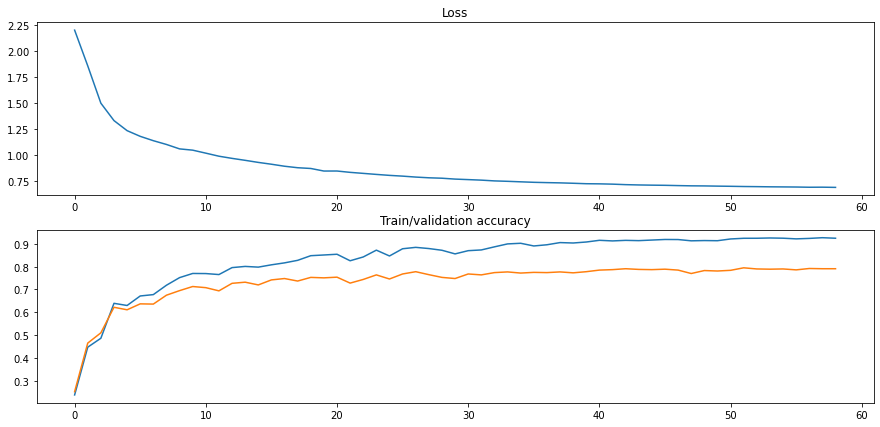

In [17]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [18]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy,))

Neural net test set accuracy: 0.759000
